## This jupyter notebook shows how to create a cellxgene VIP compatible h5ad for visualization from the following files
1. Transcript targets by cell expression
2. Cell meta information
3. Transcript target coordinate
4. Cell boundaries polygons
5. (Histology) image

download the public cosMx data from NanoString: https://nanostring.com/products/cosmx-spatial-molecular-imager/ffpe-dataset/
The seurat object contains the expression, cell meta and transcript coordinates. (some may contains cell boundaries)
If the cell boundaries are not included in the seurat. They can be estimated from the transcript coordinates by <a href="https://github.com/Nanostring-Biostats/CosMx-Analysis-Scratch-Space/tree/Main/_code/cellPoly" target="_blank">cellPoly</a>.

The following will use **Human Liver (RNA)** as an example.

### Export *Expression*, *cell meta*, *transcript coordinate* and *Reduction UMAP* from seurat object
```
require(Seurat)
require(CellPoly)
require(dplyr)
D <- readRDS('LiverDataReleaseSeurat_newUMAP.RDS')
saveSlideFOV <- function(slide,fov){
    selC <- rownames(D@meta.data)[D@meta.data$fov==fov&D@meta.data$slide_ID_numeric==slide]
    prefix <- paste0("Slide",slide,"_FOV",gsub(" ","0",format(fov,width=3)))
    data.table::fwrite(data.frame(gene=rownames(D@assays$RNA),D@assays$RNA[,selC]),paste0(prefix,'_exp.csv'))
    data.table::fwrite(data.frame(cID=selC,D@meta.data[selC,]),paste0(prefix,'_meta.csv'))
    data.table::fwrite(data.frame(cID=selC,D@reductions$approximateumap@cell.embeddings[selC,]),paste0(prefix,'_UMAP.csv'))
    data.table::fwrite(data.frame(cID=selC,D@reductions$approximateUMAP_bySlide@cell.embeddings[selC,]),paste0(prefix,'_slideUMAP.csv'))
    data.table::fwrite(D@misc$transcriptCoords[D@misc$transcriptCoords$fov==fov&D@misc$transcriptCoords$slideID==slide,] %>%
        dplyr::rename(cell_ID=cell_id),paste0(prefix,'_tx.csv'))
    polygons <- CellPoly::cellPolys(polys=list(),transcript_df=D@misc$transcriptCoords[D@misc$transcriptCoords$slideID==slide&D@misc$transcriptCoords$fov==fov,] %>%
        dplyr::select("cell_id",'x_FOV_px','y_FOV_px') %>% 
        dplyr::rename_with(~c('cell_id','x','y')))
    data.table::fwrite(dplyr::bind_rows(lapply(polygons,as.data.frame),.id='cell_id') %>% dplyr::rename_with(~c('cell_ID','x_FOV_px','y_FOV_px')),paste0(prefix,'_cellPolygons.csv'))
}

saveSlideFOV(1,2)
saveSlideFOV(1,3)
```

In [1]:
## The function to read one FOV data
import os, re
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
cellID_col = 'cell_ID'
suf_px={'local':'_local_px','global':'_global_px'}
sample_col = 'library_id'
cosMx_uns = 'cosMx'
cell_uns = 'cell_polygons'
transc_uns = 'tx_loc'
img_uns = 'images'
def readOneCapture(strExp, # the path to the expression matrix of a FOV
                   strMeta, # the path to the cell meta table matrix of a FOV
                   strReduc, # a list of the paths to the expression matrix of a FOV
                   strTargetCoord, # the path to the target coordinate of a FOV
                   strCellBoundaries, # the path to the cell boundary polygons of a FOV
                   strImg, # the image associated with the FOV, like histology please make sure the scale/rotation matching the coordinates
                   sID, #the unique name of the FOV
                   cell_column='cell_id',
                   lpx='_FOV_px', # the column suffix which indicate the location on each FOV image in cell meta table
                   gpx=4256 # the column suffix which indicate the location on the global of all FOV images in cell meta table. If a numeric, a fake global will be created vertically stack all FOVs
                  ):
    # exp
    print(" exp")
    gExp = pd.read_csv(strExp,index_col=0).T
    gExp.columns.name=None
    # meta
    print(" meta")
    cInfo = pd.read_csv(strMeta,index_col=0)
    cID = cInfo.index.intersection(gExp.index)
    # create anndata
    print(" create AnnData")
    D = ad.AnnData(X=gExp.loc[cID,:],obs=cInfo.loc[cID,:])
    del gExp
    # add px coordinates
    print(" add reduction")
    D.obsm['X_FOV_local'] = cInfo.loc[cID,[_ for _ in cInfo.columns if _.endswith(lpx)]].to_numpy('float32')
    if isinstance(gpx, (int, float)):
        FOV_global = cInfo.loc[cID,[_ for _ in cInfo.columns if _.endswith(lpx)]]
        FOV_global.iloc[:,-1] += gpx
        D.obsm['X_FOV_global'] = FOV_global.to_numpy('float32')   
    else:
        D.obsm['X_FOV_global'] = cInfo.loc[cID,[_ for _ in cInfo.columns if _.endswith(lpx)]].to_numpy('float32')    
    for oneF in strReduc:
        reducName = re.sub(".csv","",os.path.basename(oneF).split("_")[-1])
        D.obsm['X_'+reducName] = pd.read_csv(oneF,index_col=0).loc[cID,].to_numpy('float32')
    # add cell boundaries
    print(" add cell boundaries")
    D.uns[cosMx_uns]={sID:{}}
    X = pd.read_csv(strCellBoundaries)
    X.columns = [re.sub(cell_column,cellID_col,re.sub(lpx,suf_px['local'],_)) for _ in X.columns]
    if isinstance(gpx, (int, float)):
        X['x'+suf_px['global']] = X['x'+suf_px['local']]
        X['y'+suf_px['global']] = X['y'+suf_px['local']] + gpx
    else:
        X.columns = [re.sub(gpx,suf_px['global'],_) for _ in X.columns]
    D.uns[cosMx_uns][sID][cell_uns] = X    
    # add transcript coordinates
    print(" add transcript coordinates")
    X = pd.read_csv(strTargetCoord)
    X.columns = [re.sub(cell_column,cellID_col,re.sub(lpx,suf_px['local'],_)) for _ in X.columns]
    if isinstance(gpx, (int, float)):
        X['x'+suf_px['global']] = X['x'+suf_px['local']]
        X['y'+suf_px['global']] = X['y'+suf_px['local']] + gpx
    else:
        X.columns = [re.sub(gpx,suf_px['global'],_) for _ in X.columns]
    D.uns[cosMx_uns][sID][transc_uns] = X
    # add histology image
    D.uns[cosMx_uns][sID][img_uns]=plt.imread(strImg)
    return D


In [2]:
## use two FOVs from human liver data as an example

samples = {}
for i in [2,3]:
    samples['Normal%d'%i] = {}
    for one in ['exp','meta','cellPolygons','tx','reduct','img']:
        if one == 'reduct':
            samples['Normal%d'%i][one] = ['Slide1_FOV00%d_UMAP.csv'%i,'Slide1_FOV00%d_slideUMAP.csv'%i]
        elif one == 'img':
            samples['Normal%d'%i][one] = 'NormalLiverFiles/CellStatsDir/CellComposite/CellComposite_F00%d.jpg'%(i) # this can be replaced with the right histology image
        else:#
            samples['Normal%d'%i][one] = 'Slide1_FOV00%d_%s.csv'%(i,one)

adatas = []
h = 0
for sID in samples.keys():
    D = readOneCapture(samples[sID]['exp'],
                       samples[sID]['meta'],
                       samples[sID]['reduct'],
                       samples[sID]['tx'],
                       samples[sID]['cellPolygons'],
                       samples[sID]['img'],
                       sID,
                       gpx=h
                      )
    # If no global coordinates, a fake one align all of the input vertically
    h += D.uns[cosMx_uns][sID][img_uns].shape[1]
    adatas.append(D)
adata = ad.AnnData.concatenate(*adatas,
            join="outer",
            batch_categories=list(samples.keys()),
            batch_key=sample_col,
            index_unique=None,
            uns_merge='unique')
adata.uns[cosMx_uns]['keys'] = {'%s_px'%i:{j:'%s%s'%(j,suf_px[i]) for j in ['x','y']} for i in suf_px}
adata.uns[cosMx_uns]['keys']['cell'] = cell_uns
adata.uns[cosMx_uns]['keys']['tx_loc'] = transc_uns
adata.uns[cosMx_uns]['keys']['img'] = img_uns
adata.uns[cosMx_uns]['keys']['tx_col'] = 'target'
adata.write("human_liver.h5ad")

 exp
 meta
 create AnnData
 add reduction
 add cell boundaries
 add transcript coordinates
 exp
 meta
 create AnnData
 add reduction
 add cell boundaries
 add transcript coordinates


/home/zouyang/.conda/envs/SpaceSequest/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'orig.ident' as categorical
... storing 'assay_type' as categorical
... storing 'Run_name' as categorical
... storing 'Run_Tissue_name' as categorical
... storing 'Panel' as categorical
... storing 'qcFlagsRNACounts' as categorical
... storing 'qcFlagsCellCounts' as categorical
... storing 'qcFlagsCellPropNeg' as categorical
... storing 'qcFlagsCellComplex' as categorical
... storing 'qcFlagsCellArea' as categorical
... storing 'qcFlagsFOV' as categorical
... storing 'cellType' as categorical
... storing 'niche' as categorical


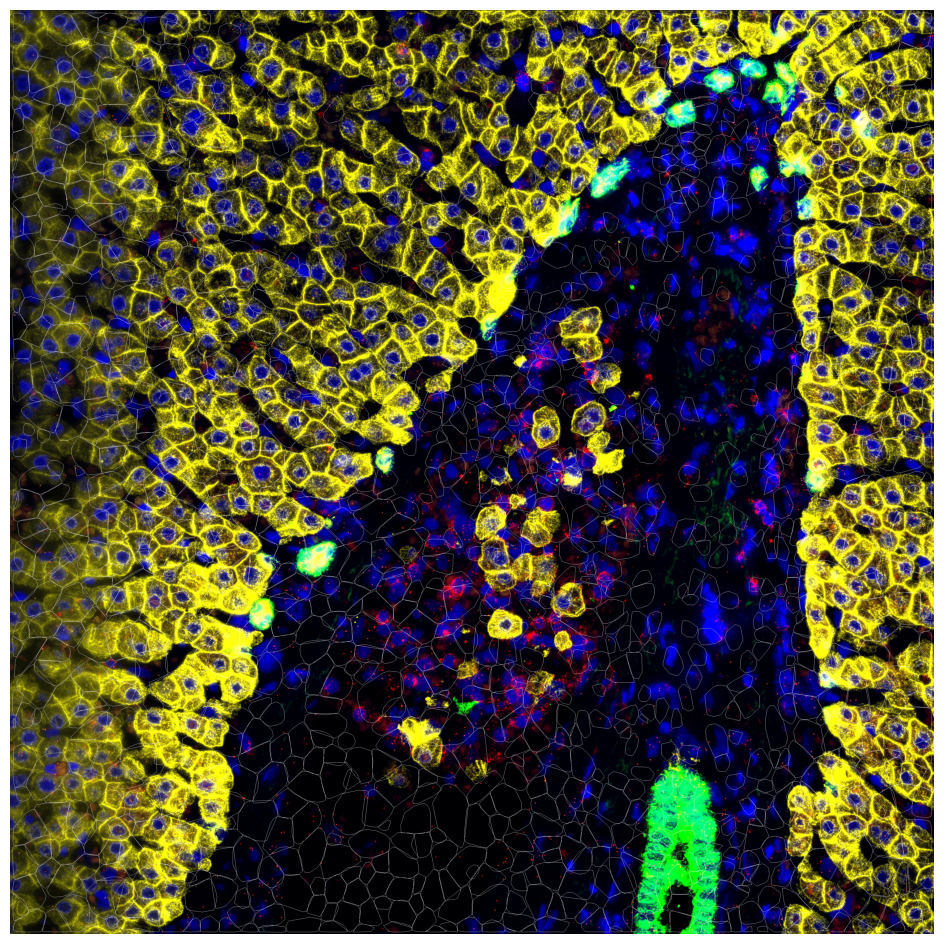

In [3]:
## visualize one FOV with cell boundaries
sID= 'Normal3'
import numpy as np
def showImg(img):
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    plt.close()
def bresenham_line(pt1,pt2):
    x1,y1 = pt1
    x2,y2 = pt2
    points = []
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    error = dx - dy
    while x1 != x2 or y1 != y2:
        points.append((x1, y1))
        e2 = 2 * error
        if e2 > -dy:
            error -= dy
            x1 += sx
        if e2 < dx:
            error += dx
            y1 += sy
    points.append((x2, y2))
    return points
def loc_img(pt,imgH):
    x,y = pt
    return((round(imgH-y),round(x)))
cosMxKey='cosMx'
keys = adata.uns[cosMxKey]['keys']
cosMxArray={}
cood_pair={}
cood_N=10
imgC = adata.uns[cosMxKey][sID][keys['img']].copy()
cell_color='ffffff'
rgb = np.array(tuple(int(cell_color[i:i+2], 16) for i in (0, 2, 4)),dtype='uint8')
cellB = adata.uns[cosMxKey][sID][keys['cell']]
for i in cellB.cell_ID.unique():
    oneC = cellB[cellB.cell_ID==i].reset_index(drop=True)
    N = oneC.shape[0]
    for j in range(N):
        p = bresenham_line(loc_img((oneC[keys['local_px']['x']][j%N],oneC[keys['local_px']['y']][j%N]),imgC.shape[1]),
                           loc_img((oneC[keys['local_px']['x']][(j+1)%N],oneC[keys['local_px']['y']][(j+1)%N]),imgC.shape[1]))
        for a in p:
            imgC[a]=rgb

showImg(imgC)